# Final Project -  KickStarter Campaigns

### ITESM - Escuela de Ingeniería y Ciencias
#### Maestría en Ciencias Computacionales
#### Aprendizaje Automático

---

## Carlos E. Hdz Rincón - A01181616

# NOTAS !

1. Usar este notebook en Kaggle para el EDA https://www.kaggle.com/soham1024/titanic-data-science-eda-with-meme-solution/notebook
1. Outlier treatment https://medium.com/towards-artificial-intelligence/outlier-detection-and-treatment-a-beginners-guide-c44af0699754

Imbalanced datasets
1. https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
1. https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23
1. https://www.jeremyjordan.me/imbalanced-data/
1. https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html


# Introduction

Crowdfunding has been increasingly getting more visibility and credibility in the past few years after having successfully funded and launched products and services.

However, despite being an option for starting projects, the rate of failed projects is still staggering. The reasons are many, but it often reduces to projects overcomitting and under-delivering promises or to projects understimating how much money it actually needed to successfully kickstart a project.

In this project, we'll try to produce a model that predicts the final state of a project in kickstarter given a set of features. In other words this will be treated as a **classification problem**.

We'll use the dataset compiled by the Kaggle user Kemical on https://www.kaggle.com/kemical/kickstarter-projects.

# Imports and tools

In [1]:
%matplotlib inline

from IPython.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler


# Connect to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def print_marquee(msg: str):
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

def print_metrics(y_true, y_pred):
    print(metrics.confusion_matrix(y_true, y_pred))
    print("Puntos no categorizados correctamente: %d/%d" 
      % ((y_true != y_pred).sum(), y_true.shape[0]))
    
    print("\n")
    print(metrics.classification_report(y_true, y_pred))

def search_and_evaluate_model(param_searcher, X, y, X_tst, y_tst, 
                              columns_to_drop: list=["ID"]):

    print_marquee("Buscando hiperparámetros óptimos...")

    param_searcher.fit(X.drop(columns_to_drop, axis=1),
                       y)
    
    print("Los mejores parámetros son %s con un score de %0.2f"
        % (param_searcher.best_params_, param_searcher.best_score_))
    

    print_marquee("Reporte de búsqueda de hiperparámetros")
    result_report = pd.DataFrame.from_dict(param_searcher.cv_results_)
    display(result_report)

    print_marquee("Matriz de confusión y reporte de predicciones en dataset de prueba:")
    y_pred = param_searcher.predict(X_tst.drop(columns_to_drop, axis=1))
    print_metrics(y_tst, y_pred)

def model_2_pkl(model, filename: str):
    pickle.dump(model, open(filename, 'wb'))

def pkl_2_model(filename: str):
    return pickle.load(open(filename, 'rb'))

# Data

The following data was pulled from over 300,000 Kickstarter projects spanning successful projects, funded but unsucessful projects or just projects that failed from the outset.

We'll try to predict the final state of the project given the properties of its crowdfunding campaign. We have the following independent variables:

## Independent Variables

1. ID (numerical). The unique ID of the project, doesn't seem to provide any statistica information.
1. name (str). The name of the campaign. We might be able to extract some information from it after tokenizing the field.
1. category (categorical). The subcategory to which the project belongs.
1. main_category (categorical). The parent category to which the project belongs.
1. currency (categorical). The currency used for the funds.
1. deadline (datetime). The hard end date of the campaign, if funds haven't been raised by this date, the project may be deemed failed.
1. goal (float). The fund raising goal for the project expressed in *currency*.
1. launched (datetime). The date at which the campaign was launched.
1. pledged (float). Pledged amount for the project in *currency*.
1. backers (int). The number of individual backers or contributors that have pledged some amount of money to the project.
1. country (categorical). The country from which the campaign was launched.
1. usd_pledged (float). The amount pledged to the project converted to USD by Kickstarter's API.
1. usd_pledged_real (float). The amount pledged to the project converted to USD by fixer.io's real time API. This amount takes into account inflation (i.e. gets the current value of the USD)
1. usd_goal_real (float).  The goal amount of the project converted to USD by fixer.io's real time API. This amount takes into account inflation (i.e. gets the current value of the USD)

## Dependent variable
1. state (categorical). Represents the final status of the crowdfunding campaign, it can be one of the following values:

 1. canceled. If the campaign was canceled by the project owners or site admins.
 1. failed. If the campaign failed to meet its goal by the deadline.
 1. live. If the campaign was successful and is now a real product or service.
 1. successful. If the campaign successfully raised at least its goal but is yet to deliver a real product or service.
 1. suspended. If the campaign has been temporarily suspended at the request of the project owners or site admins.
 1. undefined. If the state of a campaign cannot be determined with certainty.



In [3]:
data_root_location = "/content/drive/My Drive/AprendizajeAutomatico/FinalProject/"
#data_root_location = "/workspace/aprauto/FinalProject/"

data_filename = "ks-projects-201801.csv"

data = pd.read_csv(f"{data_root_location}{data_filename}",
                   header=0,
                   dtype={
                       "category": "category",
                       "main_category": "category",
                       "currency": "category",
                       "state": "category",
                       "country": "category"
                   },
                   parse_dates=["deadline", "launched"])

print(f"Data: {data.shape}")
data.head()

Data: (378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## EDA

Before we begin a proper Exploratory Data Analysis, let's begin with doing some brief description of the data: how many columns and rows there are, what are their names, how many records in each *state* category there are, etc.

In [4]:
print(f"Data Shape: {data.shape}\n")
print(f"Columns: \n{data.columns.values}\n\n")

print("Datatypes:")
data.info()

print("\n\nState Counts:")
print(data['state'].value_counts())


print("\n\nData Description:")
display(data.describe(include="all", datetime_is_numeric=True))

Data Shape: (378661, 15)

Columns: 
['ID' 'name' 'category' 'main_category' 'currency' 'deadline' 'goal'
 'launched' 'pledged' 'state' 'backers' 'country' 'usd pledged'
 'usd_pledged_real' 'usd_goal_real']


Datatypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                378661 non-null  int64         
 1   name              378657 non-null  object        
 2   category          378661 non-null  category      
 3   main_category     378661 non-null  category      
 4   currency          378661 non-null  category      
 5   deadline          378661 non-null  datetime64[ns]
 6   goal              378661 non-null  float64       
 7   launched          378661 non-null  datetime64[ns]
 8   pledged           378661 non-null  float64       
 9   state             378661 non-null  category      
 10  backe

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,NaN,375764,159,15,14,NaN,NaN,NaN,NaN,6,NaN,23,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,NaN,NaN,NaN,NaN,failed,NaN,US,NaN,NaN,NaN
freq,NaN,41,22314,63585,295365,NaN,NaN,NaN,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,2014-11-01 16:04:27.950423808,4.908079e+04,2014-09-28 18:06:17.416493568,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
min,5.971000e+03,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,1.000000e-02,1970-01-01 01:00:00,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,2013-06-08 00:00:00,2.000000e+03,2013-05-07 22:14:27,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,2015-01-14 00:00:00,5.200000e+03,2014-12-10 03:23:41,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,2016-04-28 00:00:00,1.600000e+04,2016-03-24 10:21:09,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,1.000000e+08,2018-01-02 15:02:31,2.033899e+07,NaN,219382.000000,NaN,2.033899e+07,2.033899e+07,1.663614e+08


### Data Description

This first round of analysis brings some really good insight. For starters, we can see that the dataset is quite imbalanced, the *undefined, live and suspended* states are very little in comparison to the failed and successful. We can also see that failed projects are more common on Kickstarter.

We can also see that most of the projects use USD as currency, they usually ask for around \$45,000 USD, have around 100 backers, but they only raise just under \$10,000 USD which seems to show that while crowdfunding has been getting more popular in the past few years, people still pledge to a campaign cautiously.

There is missing data in some of the columns, but we'll discuss that in a bit.



## Missing values

In [8]:
data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

*usd_pledged* is missing data but we can ignore the whole column as this is redundant and *usd_pledged_real* has better data.

Name has missing very few records with no information, so we could fill it with "N/A" for now.

In [9]:
data["name"].fillna("N/A", inplace=True)
data.drop(["usd pledged"], axis=1, inplace=True)

data.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

## Categorical values

Let's inspect what kind of categories we have and how many of each there are.

In [5]:
def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int):

    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=20,
                          legend=True)

In [6]:
categorical_cols = [
                "category",
                "main_category",
                "currency",
                "country",
                "state"
]

for cat_col in categorical_cols:
    unique_vals = data[cat_col].cat.categories.values
    print(f"{cat_col}({len(unique_vals)}):")
    print(f"{unique_vals}\n")

category(159):
['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin

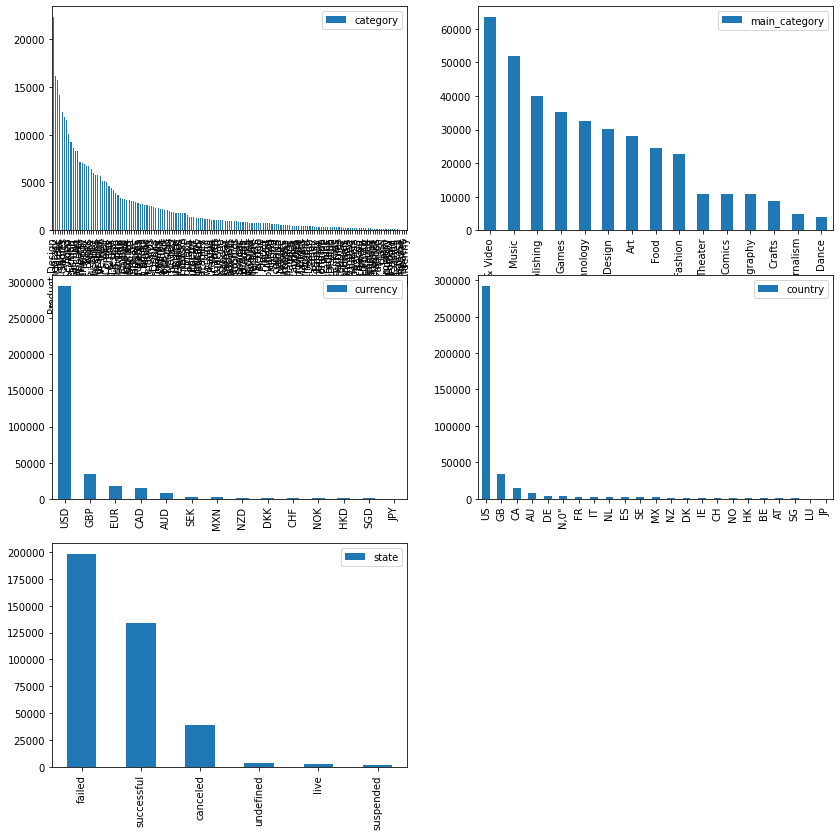

In [7]:
fig_count = plt.figure()

for idx, cat_col in enumerate(categorical_cols):
    ax = fig_count.add_subplot(3, 2, idx + 1)

    data[cat_col].value_counts().plot(kind='bar',
                                      ax=ax,
                                      figsize=(14,14),
                                      legend=True)

plt.show()

As mentioned before, we can see that the dependant categorical column represents an imbalanced dataset.

We can also visually confirm that most of the projects are US-based and thus use USD as its currency.

## Data Transformations and Feature Engineering

After removing the *usd pledge* column and filling the 4 missing values in name. The next things we can do is:

### 1 Drop the pledged and goal columns

Much like the *usd pledge* column, since we will use *usd_pledged_real* and *usd_pledged_goal* we can also drop the *pledged* and *goal* columns as they are now redundant.

Moreover, we want all money data to be in the same currency to better compare apples-to-apples.

In [10]:
data_fixed = data.copy()

data_fixed.drop(["pledged", "goal"], axis=1, inplace=True)

### 2 Change the category columns to discrete numerical values.


In [11]:
for cat_col in categorical_cols:    
    data_fixed[cat_col] = data_fixed[cat_col].astype('category').cat.codes


data_fixed[categorical_cols].head(5)


,category,main_category,currency,country,state
0,108,12,5,9,1
1,93,6,13,22,1
2,93,6,13,22,1
3,90,10,13,22,1
4,55,6,13,22,0


### 3 Create a new column *campaign_duration_days* that stores the difference between the deadline - launched and remove both columns.

In [12]:
data_fixed["campaign_duration_days"] = \
    (data_fixed.deadline - data_fixed.launched).astype('timedelta64[D]')

data_fixed[["launched", "deadline", "campaign_duration_days"]].head(10)

,launched,deadline,campaign_duration_days
0,2015-08-11 12:12:28,2015-10-09,58.0
1,2017-09-02 04:43:57,2017-11-01,59.0
2,2013-01-12 00:20:50,2013-02-26,44.0
3,2012-03-17 03:24:11,2012-04-16,29.0
4,2015-07-04 08:35:03,2015-08-29,55.0
5,2016-02-26 13:38:27,2016-04-01,34.0
6,2014-12-01 18:30:44,2014-12-21,19.0
7,2016-02-01 20:05:12,2016-03-17,44.0
8,2014-04-24 18:14:43,2014-05-29,34.0
9,2014-07-11 21:55:48,2014-08-10,29.0


In [13]:
data_fixed.drop(["launched", "deadline"], axis=1, inplace=True)
data_fixed.head(5)

,ID,name,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,campaign_duration_days
0,1000002330,The Songs of Adelaide & Abullah,108,12,5,1,0,9,0.0,1533.95,58.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,1,15,22,2421.0,30000.00,59.0
2,1000004038,Where is Hank?,93,6,13,1,3,22,220.0,45000.00,44.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,1,1,22,1.0,5000.00,29.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,55,6,13,0,14,22,1283.0,19500.00,55.0


### 4 Tokenize the *name* column, remove stop words and encode the presence of the top 50 most common tokens.

Let's first see if there are records that share the same exact name and how many records there are.

In [14]:
cnt = data_fixed.groupby(["name"]).size().reset_index(name='count')
cnt[cnt["count"] > 1].sort_values(by=['count'], ascending=False)

,name,count
212354,New EP/Music Development,41
65438,Canceled (Canceled),13
205249,Music Video,11
208195,N/A (Canceled),11
212334,New EP / Music Development,10
...,...,...
138805,Harvard Student Art Show,2
138566,Hare Watches,2
138545,Hardwire Media Center,2
138067,Hannah's Huggables,2


We see that there are various projects with the same name, we can tokenize and encode the presence of the most common tokens.

We'll use a Tfidf Vectorizer to determine those terms that are most relevant in the whole corpus of the name column, to do this, we'll:
1. Strip any accent characters
1. Remove stop words
1. Limit it to the 50 most important tokens
1. A valid token is one that is at least 2 letters and may have additional alphanumerical characters. The tokens will be converted to lowercase
1. These new 50 features for each row will replace the *name* column in the data, we'll prefix these new columns with *name_* so as to remember where they came from.

In [15]:
vectorizer = TfidfVectorizer(
    strip_accents="unicode",
    stop_words=ENGLISH_STOP_WORDS,
    binary=False,
    max_features=50,
    token_pattern=u'(?ui)\\b\\w*[a-z]{2,}\\w*\\b'
)
word_tfidf_vector = vectorizer.fit_transform(data_fixed["name"])

print(f"Top TF-IDF Tokens to generate {word_tfidf_vector.shape} tokens:")
print(vectorizer.get_feature_names())

Top TF-IDF Tokens to generate (378661, 50) tokens:
['adventure', 'album', 'american', 'app', 'art', 'book', 'canceled', 'card', 'cards', 'cd', 'children', 'city', 'clothing', 'collection', 'comic', 'dance', 'debut', 'documentary', 'ep', 'feature', 'festival', 'film', 'food', 'free', 'game', 'help', 'home', 'kids', 'life', 'live', 'love', 'magazine', 'make', 'man', 'mobile', 'movie', 'music', 'new', 'novel', 'playing', 'project', 'record', 'series', 'short', 'story', 'studio', 'time', 'tour', 'video', 'world']


In [16]:
name_features = pd.DataFrame(word_tfidf_vector.toarray(),
                             columns=vectorizer.get_feature_names())
name_features = name_features.add_prefix("name_")
display(name_features.head(5))

,name_adventure,name_album,name_american,name_app,name_art,name_book,name_canceled,name_card,name_cards,name_cd,name_children,name_city,name_clothing,name_collection,name_comic,name_dance,name_debut,name_documentary,name_ep,name_feature,name_festival,name_film,name_food,name_free,name_game,name_help,name_home,name_kids,name_life,name_live,name_love,name_magazine,name_make,name_man,name_mobile,name_movie,name_music,name_new,name_novel,name_playing,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.646081,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.763269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.608472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.561517,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.560767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
data_fixed_2 = data_fixed.copy()

data_fixed_2 = pd.concat([data_fixed_2, name_features], axis=1)

display(data_fixed_2)

,ID,name,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,campaign_duration_days,name_adventure,name_album,name_american,name_app,name_art,name_book,name_canceled,name_card,name_cards,name_cd,name_children,name_city,name_clothing,name_collection,name_comic,name_dance,name_debut,name_documentary,name_ep,name_feature,name_festival,name_film,name_food,name_free,name_game,name_help,name_home,name_kids,name_life,name_live,name_love,name_magazine,name_make,name_man,name_mobile,name_movie,name_music,name_new,name_novel,name_playing,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
0,1000002330,The Songs of Adelaide & Abullah,108,12,5,1,0,9,0.0,1533.95,58.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,1,15,22,2421.0,30000.00,59.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000004038,Where is Hank?,93,6,13,1,3,22,220.0,45000.00,44.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,1,1,22,1.0,5000.00,29.0,0.0,0.646081,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.763269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,55,6,13,0,14,22,1283.0,19500.00,55.0,0.0,0.000000,0.0,0.0,0.608472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.561517,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.560767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),39,6,13,0,1,22,25.0,50000.00,29.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378657,999977640,The Tribe,93,6,13,1,5,22,155.0,1500.00,26.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,93,6,13,1,1,22,20.0,15000.00,45.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815023,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579428,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378659,999987933,BioDefense Education Kit,138,13,13,1,6,22,200.0,15000.00,30.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Remove the *name* column and see that all data is now numerical

In [18]:
data_fixed_2.drop("name", axis=1, inplace=True)
data_fixed_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 60 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      378661 non-null  int64  
 1   category                378661 non-null  int16  
 2   main_category           378661 non-null  int8   
 3   currency                378661 non-null  int8   
 4   state                   378661 non-null  int8   
 5   backers                 378661 non-null  int64  
 6   country                 378661 non-null  int8   
 7   usd_pledged_real        378661 non-null  float64
 8   usd_goal_real           378661 non-null  float64
 9   campaign_duration_days  378661 non-null  float64
 10  name_adventure          378661 non-null  float64
 11  name_album              378661 non-null  float64
 12  name_american           378661 non-null  float64
 13  name_app                378661 non-null  float64
 14  name_art            

## Outlier analysis

Let's begin with a histogram frequency count for each of the columns, we want to ignore the ID as it does not provide significant frequency data. We'll take a look at how the categorical data looks like.

We'll also ignore the *name_* columns given how many and how sparse they are.

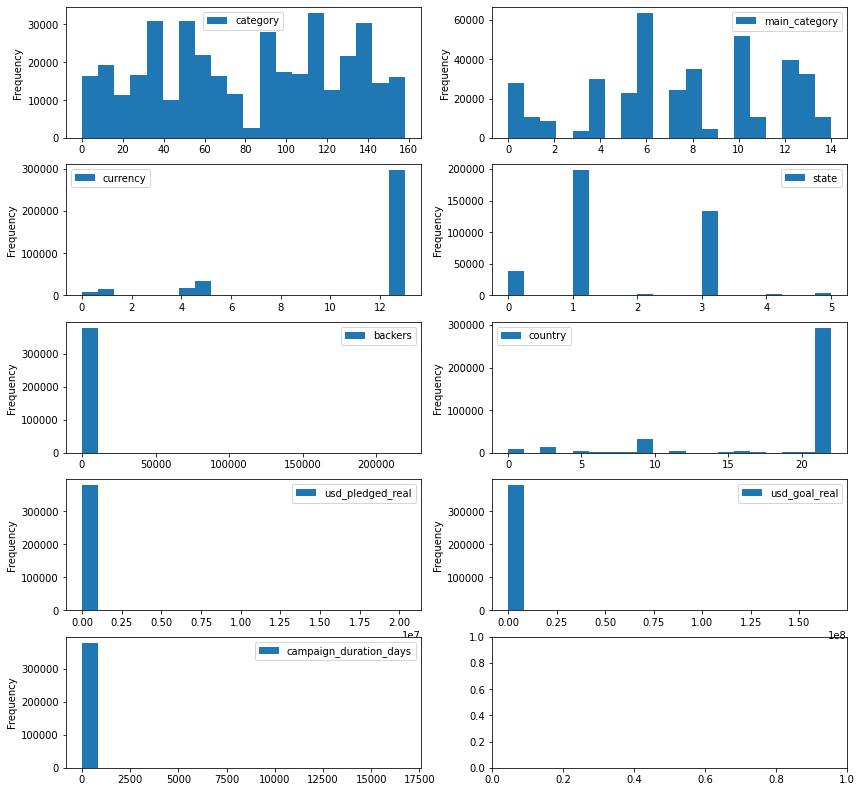

In [19]:
def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int, bins: int=20):

    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=bins,
                          legend=True)
# We don't want to plot the name_ features nor the ID column
columns_to_ignore = ["ID"]
columns_to_ignore.extend(list(data_fixed_2.filter(regex = 'name_')))
plot_histogram(data_fixed_2.drop(columns_to_ignore, axis=1), 5, 2)

In these histograms we see that there are categories that represent a big count. The data in these categories is unbalanced specially for the currency and country columns.

Let's see if there are many outliers in the data with a box plot. We'll focus strictly on the numerical data in:
1. usd_goal_real
1. usd_pledged_real
1. backers
1. campaign_duration_days

In [20]:
numerical_columns = ["usd_goal_real",
             'usd_pledged_real',
             "backers",
             "campaign_duration_days"]

data_fixed_2[numerical_columns].describe()

,usd_goal_real,usd_pledged_real,backers,campaign_duration_days
count,3.786610e+05,3.786610e+05,378661.000000,378661.000000
mean,4.545440e+04,9.058924e+03,105.617476,33.481122
std,1.152950e+06,9.097334e+04,907.185035,65.909172
min,1.000000e-02,0.000000e+00,0.000000,0.000000
25%,2.000000e+03,3.100000e+01,2.000000,29.000000
50%,5.500000e+03,6.243300e+02,12.000000,29.000000
75%,1.550000e+04,4.050000e+03,56.000000,36.000000
max,1.663614e+08,2.033899e+07,219382.000000,16738.000000


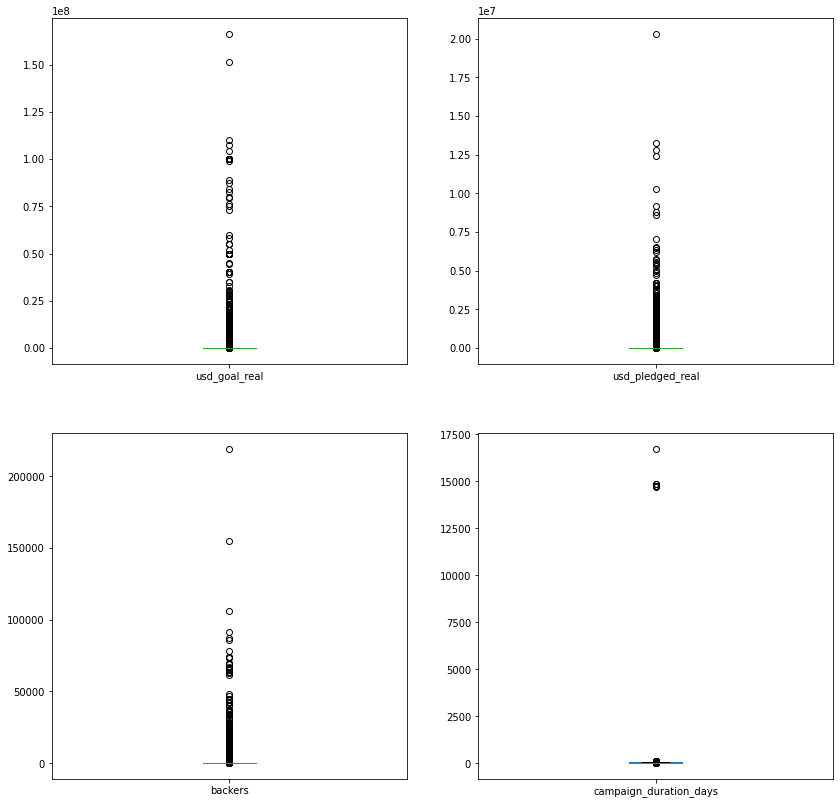

In [21]:
data_fixed_2[numerical_columns].plot.box(subplots=True,
                                       layout=(2, 2),
                                       figsize=(14,14));

All columns have many outliers and have varying ranges of the data, which might not matter too much in some models like Decision Trees or Random Forest but will on some others.

Let's zoom in and check  how many records with outliers there are with InterQuartile Range (IQR).

Anything inside of the $IQR*1.5$ will be not be considered an outlier, anything over or under the $IQR*3.0$ will be considered an outlier.

In [22]:
def describe_outliers_with_iqr(df: pd.DataFrame):

    for col in df.columns:
        column_data = df[col]
        iqr = column_data.quantile(0.75) - column_data.quantile(0.25)
        
        upper_limit = column_data.quantile(0.75) + (iqr * 1.5)
        upper_limit_extreme = column_data.quantile(0.75) + (iqr * 3)

        lower_limit = column_data.quantile(0.25) - (iqr * 1.5)
        lower_limit_extreme = column_data.quantile(0.25) - (iqr * 3)

        num_outliers_below_lower = df[df[col] < lower_limit_extreme].shape[0]
        num_outliers_above_upper = df[df[col] > upper_limit_extreme].shape[0]

        print_marquee(f"Outlier data for column {col}")
        print(f"IQR: {iqr}")
        print(f"Lower limit extreme: {lower_limit_extreme}")
        print(f"Lower limit: {lower_limit}")
        print(f"Upper limit: {upper_limit}")
        print(f"Upper limit extreme: {upper_limit_extreme}")

        print(f"Outliers below the lower limit: {num_outliers_below_lower}")
        print(f"Outliers above the upper limit: {num_outliers_above_upper}")


describe_outliers_with_iqr(data_fixed_2[numerical_columns])



*****************************************
* Outlier data for column usd_goal_real *
*****************************************
IQR: 13500.0
Lower limit extreme: -38500.0
Lower limit: -18250.0
Upper limit: 35750.0
Upper limit extreme: 56000.0
Outliers below the lower limit: 0
Outliers above the upper limit: 26943


********************************************
* Outlier data for column usd_pledged_real *
********************************************
IQR: 4019.0
Lower limit extreme: -12026.0
Lower limit: -5997.5
Upper limit: 10078.5
Upper limit extreme: 16107.0
Outliers below the lower limit: 0
Outliers above the upper limit: 32535


***********************************
* Outlier data for column backers *
***********************************
IQR: 54.0
Lower limit extreme: -160.0
Lower limit: -79.0
Upper limit: 137.0
Upper limit extreme: 218.0
Outliers below the lower limit: 0
Outliers above the upper limit: 29013


**************************************************
* Outlier data for column

Given the big number of outliers, we can't just trim them out of the dataset, instead we will cap the outliers to be the value of the lower and upper limit extremes.

1. usd_goal_real
 * No outliers below the limit
 * Will cap higher outliers to 56000.0 
1. usd_pledged_real
 * No outliers below the limit
 * Will cap higher outliers to 16107.0
1. backers
 * No outliers below the limit
 * Will cap higher outliers to 218
1. campaign_duration_days
 * Will cap lower outliers to 8
 * Will cap higher outliers to 57

In [23]:
data_fixed_3 = data_fixed_2.copy()


data_fixed_3.loc[data_fixed_3["usd_goal_real"] > 56000, "usd_goal_real"] = 56000
data_fixed_3.loc[data_fixed_3["usd_pledged_real"] > 16107, "usd_pledged_real"] = 16107
data_fixed_3.loc[data_fixed_3["backers"] > 218, "backers"] = 218

data_fixed_3.loc[data_fixed_3["campaign_duration_days"] < 8, "campaign_duration_days"] = 8
data_fixed_3.loc[data_fixed_3["campaign_duration_days"] > 57, "campaign_duration_days"] = 57

In [24]:
data_fixed_3[numerical_columns].describe()

,usd_goal_real,usd_pledged_real,backers,campaign_duration_days
count,378661.000000,378661.000000,378661.000000,378661.000000
mean,12993.869713,3260.603605,44.220081,32.747125
std,16440.022262,5055.867207,65.677192,11.391515
min,0.010000,0.000000,0.000000,8.000000
25%,2000.000000,31.000000,2.000000,29.000000
50%,5500.000000,624.330000,12.000000,29.000000
75%,15500.000000,4050.000000,56.000000,36.000000
max,56000.000000,16107.000000,218.000000,57.000000


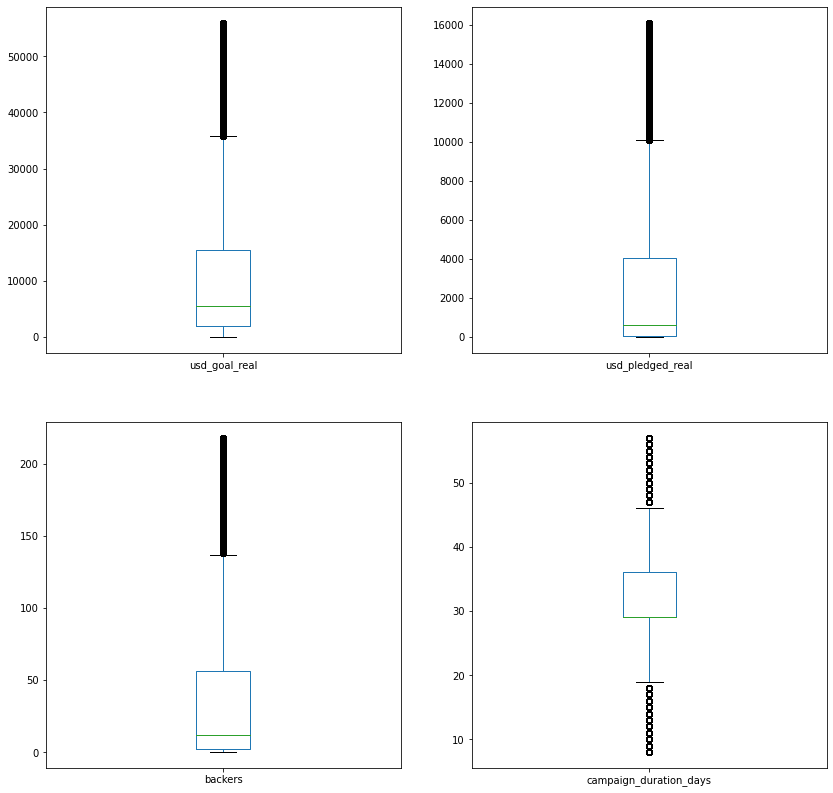

In [34]:
data_fixed_3[numerical_columns].plot.box(subplots=True,
                                       layout=(2, 2),
                                       figsize=(14,14));

In the table and the graphs we can now see that all values in numerical columns are not above or below the $3*IQR$ and that most of the data points are inside of the IQR.

## Data Normalization
Let's further process these four numerical columns in the data by using Robust Scaling.

In robust scaling, we scale each feature of the data set by subtracting the median and then dividing by the interquartile range. The interquartile range (IQR) is defined as the difference between the third and the first quartile and represents the central 50% of the data.

This method comes in handy when working with data sets that contain many outliers because it uses statistics that are robust to outliers (median and interquartile range).

In [25]:
data_fixed_4 = data_fixed_3.copy()

print("Before scaling:")
display(data_fixed_4[numerical_columns].describe())

print("\n\nScaled data:")
data_fixed_4[numerical_columns] = pd.DataFrame(
    
    ().fit_transform(data_fixed_3[numerical_columns]),
    columns=numerical_columns)

display(data_fixed_4[numerical_columns].describe())

Before scaling:


,usd_goal_real,usd_pledged_real,backers,campaign_duration_days
count,378661.000000,378661.000000,378661.000000,378661.000000
mean,12993.869713,3260.603605,44.220081,32.747125
std,16440.022262,5055.867207,65.677192,11.391515
min,0.010000,0.000000,0.000000,8.000000
25%,2000.000000,31.000000,2.000000,29.000000
50%,5500.000000,624.330000,12.000000,29.000000
75%,15500.000000,4050.000000,56.000000,36.000000
max,56000.000000,16107.000000,218.000000,57.000000




Scaled data:


,usd_goal_real,usd_pledged_real,backers,campaign_duration_days
count,378661.000000,378661.000000,378661.000000,378661.000000
mean,0.555101,0.655953,0.596668,0.535304
std,1.217779,1.257991,1.216244,1.627359
min,-0.407407,-0.155345,-0.222222,-3.000000
25%,-0.259259,-0.147631,-0.185185,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.740741,0.852369,0.814815,1.000000
max,3.740741,3.852369,3.814815,4.000000


We can now see that after treating the outliers and normalizing the data, all columns are roughly inside a similar range and so are the std deviation and means of the data.

It's important to note that after normalization, data may not directly tell us what its value means, i.e: there can't be negative backers or campaign days. But for the model, the normalization helps it to get better results.

## Correlation Matrix

In [26]:
corr_matrix = data_fixed_4.drop(["ID"], axis=1).corr(method="pearson")
display(corr_matrix)

,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,campaign_duration_days,name_adventure,name_album,name_american,name_app,name_art,name_book,name_canceled,name_card,name_cards,name_cd,name_children,name_city,name_clothing,name_collection,name_comic,name_dance,name_debut,name_documentary,name_ep,name_feature,name_festival,name_film,name_food,name_free,name_game,name_help,name_home,name_kids,name_life,name_live,name_love,name_magazine,name_make,name_man,name_mobile,name_movie,name_music,name_new,name_novel,name_playing,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
category,1.000000,0.199092,-0.012265,0.014103,0.070809,-0.012868,0.057243,0.044042,-0.003565,0.019710,0.012681,-0.007626,-0.066738,-0.052802,-0.062636,0.020936,0.061835,0.026736,-0.000057,-0.061299,0.000717,-0.075855,-0.031886,-0.061951,-0.021149,0.004295,-0.083723,0.011395,-0.014034,0.002544,0.008178,-0.018508,0.004539,0.139351,-0.001820,-0.003477,-0.020516,-0.002583,0.004330,-0.003649,0.028604,-0.006103,0.000648,-0.005845,-0.016382,0.004267,0.013383,-0.037603,0.037140,-0.005262,0.006314,0.011578,0.042440,-0.020872,-0.004415,-0.000155,0.014384,0.018448,0.014827
main_category,0.199092,1.000000,-0.013927,-0.014582,-0.019586,-0.014337,-0.007589,0.065789,0.038640,0.008478,0.119239,-0.001349,0.103571,-0.160731,0.077335,0.001182,-0.001320,-0.022289,0.055181,0.045673,-0.005639,-0.047440,-0.040656,-0.102043,-0.059537,0.068537,-0.036076,0.070007,-0.029912,0.012104,-0.062894,-0.005800,0.006277,0.019058,0.023396,0.007686,0.010914,0.010577,0.021529,0.008189,0.058619,0.001696,-0.027558,0.025728,-0.026059,0.056649,0.051624,0.014663,-0.001443,-0.014536,0.048589,-0.023974,-0.038445,0.021791,-0.008315,0.006954,0.038610,0.012664,0.014613
currency,-0.012265,-0.013927,1.000000,0.057808,0.046238,0.979487,0.046657,-0.028996,0.017088,-0.003068,0.039663,0.026217,-0.023424,0.002364,0.004273,-0.014955,-0.007041,-0.009609,0.028051,0.002471,0.010305,-0.004405,0.000381,0.004777,0.013753,0.023938,0.020107,0.020200,0.013470,0.002641,0.012913,0.006643,-0.002593,-0.017033,0.015555,-0.001240,0.004896,0.002016,0.003422,0.012249,-0.009468,0.002833,0.010652,-0.000926,0.012718,0.018934,0.021912,0.010194,-0.005725,0.028341,0.026208,0.017849,-0.005772,0.011870,0.008729,0.000576,0.023652,0.009718,-0.022550
state,0.014103,-0.014582,0.057808,1.000000,0.515970,0.045667,0.499935,-0.232921,-0.116876,0.003639,0.093524,-0.004415,-0.045581,0.007181,0.012712,-0.361961,0.001905,0.012788,0.032515,-0.002029,0.010038,-0.030040,0.004495,0.015544,0.026316,0.063612,0.010677,0.060799,0.004178,0.031070,0.047317,-0.018181,-0.005093,-0.016479,0.014280,-0.003213,-0.007488,-0.015072,0.003874,0.002063,0.000619,0.011475,0.010702,-0.021210,-0.009092,0.017435,0.049331,-0.000269,0.013355,0.004078,0.046624,-0.006185,0.049080,-0.001704,0.017215,-0.003443,0.023044,0.004852,-0.004659
backers,0.070809,-0.019586,0.046238,0.515970,1.000000,0.046130,0.885409,0.132613,-0.033210,0.024009,0.029851,-0.003090,-0.031824,-0.019352,0.013840,-0.106378,0.045772,0.064101,-0.002095,-0.005909,0.009691,-0.029892,0.002562,0.015949,-0.005638,0.010080,0.028713,-0.012919,0.017413,-0.005332,0.006247,-0.008273,-0.003151,0.063989,-0.023440,0.004724,-0.001279,-0.014666,-0.004069,-0.009197,0.002641,0.003825,-0.000805,-0.006387,-0.002716,-0.025054,0.031983,0.008858,0.087107,-0.023548,0.021586,-0.007112,-0.010821,0.002055,-0.003889,0.000121,-0.011388,-0.018273,0.035752
country,-0.012868,-0.014337,0.979487,0.045667,0.046130,1.000000,0.045011,-0.024676,0.019129,-0.002464,0.036223,0.026012,-0.022047,0.002008,0.004139,-0.013257,-0.006835,-0.009591,0.025945,0.002249,0.010316,-0.004974,0.000173,0.004294,0.013658,0.021620,0.019936,0.016841,0.012765,0.001633,0.011873,0.007180,-0.001865,-0.015893,0.014738,-0.001201,0.005168,0.001736,0.003012,0.012469,-0.009528,0.003450,0.010214,-0.000524,0.012522,0.016908,0.020690,0.010001,-0.006076,0.027826,0.024287,0.016868,-0.006843,0.012

Let's get the independent variables that strongly correlate to the dependent variable *state*

In [27]:
display(corr_matrix[np.abs(corr_matrix["state"]) > 0.4]["state"])

state               1.000000
backers             0.515970
usd_pledged_real    0.499935
Name: state, dtype: float64

We see that the *backers and usd_pledged_real* are the ones that best correlate to state, which makes sense because the ammount of backers and how much money they contribute to a campaign dictates the success or failure of a project in Kickstarter.

It'd be interesting to see if there are columns that don't really correlate (less than 0.1) to the state variable as these might help simplify the model later on.

In [28]:
display(corr_matrix[np.abs(corr_matrix["state"]) < 0.1]["state"])

category            0.014103
main_category      -0.014582
currency            0.057808
country             0.045667
name_adventure      0.003639
name_album          0.093524
name_american      -0.004415
name_app           -0.045581
name_art            0.007181
name_book           0.012712
name_card           0.001905
name_cards          0.012788
name_cd             0.032515
name_children      -0.002029
name_city           0.010038
name_clothing      -0.030040
name_collection     0.004495
name_comic          0.015544
name_dance          0.026316
name_debut          0.063612
name_documentary    0.010677
name_ep             0.060799
name_feature        0.004178
name_festival       0.031070
name_film           0.047317
name_food          -0.018181
name_free          -0.005093
name_game          -0.016479
name_help           0.014280
name_home          -0.003213
name_kids          -0.007488
name_life          -0.015072
name_live           0.003874
name_love           0.002063
name_magazine 

It would appear that the presence of certain words in the name column don't really impact the state of a project, if the models are not performing well, we might want to consider removing them from the training so as to reduce the noise.

## Train/Val/Test Split

We'll use a 80/10/10 split for the train/val/test sets.

In [29]:
def train_val_test_split(X: pd.DataFrame, y: pd.DataFrame,
                         should_print_summary: bool = True):
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    # Val/Test split
    X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    train_size=0.5,
                                                    random_state=42)

    # Ravel the labels to get it in better shape for the training
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    if should_print_summary:
        print(f"X_train: {X_train.shape}")
        print(f"X_val: {X_val.shape}")
        print(f"X_test: {X_test.shape}")

        print(f"y_train: {y_train.shape}")
        print(f"y_val: {y_val.shape}")
        print(f"y_test: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test


data_final = data_fixed_4.copy()

dependent_var = "state";

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    data_final.drop(dependent_var, axis=1),
    data_final[[dependent_var]])


X_train: (302928, 59)
X_val: (37866, 59)
X_test: (37867, 59)
y_train: (302928,)
y_val: (37866,)
y_test: (37867,)


In [30]:
unique, counts = np.unique(y_test, return_counts=True)
print(data["state"].value_counts())
print(dict(zip(unique, counts)))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
{0: 3946, 1: 19671, 2: 308, 3: 13417, 4: 183, 5: 342}


# Models

Now, we'll take the data and train on it for the following models:

1. MLP Neural Network
1. SVM
1. Random Forest
1. Decision tree
1. Logistic Regression
1. Gaussian Naïve Bayes

We'll use accuracy as the main metric to evaluate the performance, but we'll keep an eye on the precision, recall and F1-Score in order to break ties.

## MLP Neural Network

In [ ]:
hyperparams_mlp = {
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.0003, 0.009, 0.01, 0.03, 0.1, 0.3, 0],
    "batch_size": ["auto"],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "learning_rate_init": [0.001, 0.003, 0.009],
    "shuffle": [True, False],
    "nesterovs_momentum": [True, False],
    }

mlp_search = RandomizedSearchCV(MLPClassifier(random_state=42,
                                              early_stopping=True
                                              ),
                                param_distributions=hyperparams_mlp,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(mlp_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(mlp_search.best_estimator_,
            f"{data_root_location}mlp_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 24.9min finished


Los mejores parámetros son {'solver': 'adam', 'shuffle': True, 'nesterovs_momentum': False, 'learning_rate_init': 0.009, 'learning_rate': 'invscaling', 'batch_size': 'auto', 'alpha': 0, 'activation': 'logistic'} con un score de 0.93


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_shuffle,param_nesterovs_momentum,param_learning_rate_init,param_learning_rate,param_batch_size,...,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,88.525095,56.080082,0.387387,0.084221,sgd,False,False,0.009,constant,auto,...,tanh,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.666326,0.819397,0.720645,0.618404,0.823174,0.729589,0.081570,95
1,441.014786,13.455834,0.237609,0.075608,sgd,True,True,0.001,adaptive,auto,...,relu,"{'solver': 'sgd', 'shuffle': True, 'nesterovs_...",0.920922,0.918760,0.919288,0.920723,0.919419,0.919823,0.000848,52
2,178.315003,48.356476,0.456798,0.054532,adam,True,False,0.001,adaptive,auto,...,tanh,"{'solver': 'adam', 'shuffle': True, 'nesterovs...",0.931750,0.931898,0.931189,0.934274,0.932260,0.932274,0.001058,11
3,184.429929,59.006539,0.306244,0.039649,adam,False,True,0.003,adaptive,auto,...,relu,"{'solver': 'adam', 'shuffle': False, 'nesterov...",0.931321,0.932245,0.930413,0.928316,0.929223,0.930304,0.001410,27
4,138.600102,61.728223,0.187143,0.010830,sgd,False,False,0.003,invscaling,auto,...,relu,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.782276,0.782194,0.771779,0.784930,0.775373,0.779311,0.004918,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,92.929492,25.318263,0.171443,0.011116,adam,False,False,0.009,adaptive,auto,...,relu,"{'solver': 'adam', 'shuffle': False, 'nesterov...",0.930941,0.932707,0.926254,0.930346,0.929966,0.930043,0.002115,33
96,90.781639,32.542482,0.373254,0.070742,sgd,False,False,0.009,constant,auto,...,logistic,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.824861,0.757172,0.843611,0.781084,0.803681,0.802082,0.030672,83
97,137.193595,25.015083,0.259948,0.065743,adam,False,False,0.001,constant,auto,...,logistic,"{'solver': 'adam', 'shuffle': False, 'nesterov...",0.903740,0.904747,0.902931,0.900322,0.902501,0.902848,0.001477,64
98,110.546218,23.326557,0.297393,0.051841,sgd,False,True,0.001,constant,auto,...,tanh,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.892302,0.859704,0.892384,0.870777,0.859668,0.874967,0.014754,76




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[ 2383  1510     0    70     1     0]
 [    3 19501     0   234     1    16]
 [    1   193     0    52     0     0]
 [   12    87     3 13221     0    12]
 [    1   166     0    29     0     0]
 [    0     4     0     1     0   365]]
Puntos no categorizados correctamente: 2396/37866


              precision    recall  f1-score   support

           0       0.99      0.60      0.75      3964
           1       0.91      0.99      0.95     19755
           2       0.00      0.00      0.00       246
           3       0.97      0.99      0.98     13335
           4       0.00      0.00      0.00       196
           5       0.93      0.99      0.96       370

    accuracy                           0.94     37866
   macro avg       0.63      0.59      0.61     37866
weighte

## SVM TBD !!!!

In [ ]:
rus = RandomUnderSampler(random_state=42,
                         replacement=True,
                         sampling_strategy={
                             0:7000,
                             1:7000,
                             3:7000
                         })
rus.fit_resample(data_final.drop(["ID", "state"], axis=1),
                 data_final[[dependent_var]])

data_resampled = data_final.loc[rus.sample_indices_]

X_train_resamp, X_val_resamp, X_test_resamp, \
 y_train_resamp, y_val_resamp, y_test_resamp = train_val_test_split(
    data_resampled.drop(dependent_var, axis=1),
    data_resampled[[dependent_var]],
    False)

hyperparams_svc = {
    "C": [0.1, 1],
    "kernel": [
               "linear",
               #"poly",
               "rbf",
               #"sigmoid"
               ],
    #"degree": [1,2,3,4],
    "gamma": ["scale", "auto"],
}

svc_search = RandomizedSearchCV(SVC(random_state=42),
                                param_distributions=hyperparams_svc,
                                verbose=3,
                                n_jobs=-1,
                                cv=2,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=4)

search_and_evaluate_model(svc_search,
                          X_train_resamp,
                          y_train_resamp,
                          X_val_resamp,
                          y_val_resamp)

model_2_pkl(svc_search.best_estimator_,
            f"{data_root_location}svc_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 11.7min finished


Los mejores parámetros son {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1} con un score de 0.66


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,30.948694,0.213202,18.849785,0.001803,rbf,scale,0.1,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}",0.317812,0.323575,0.320693,0.002881,4
1,27.944892,0.181442,17.593694,0.114407,rbf,scale,1,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 1}",0.443893,0.442219,0.443056,0.000837,3
2,550.302233,16.671190,8.220111,0.038209,linear,scale,0.1,"{'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}",0.658992,0.656994,0.657993,0.000999,1
3,18.725168,1.511428,12.724803,1.319092,rbf,auto,1,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 1}",0.615510,0.620613,0.618061,0.002552,2




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[427 216   0  40   0  18]
 [  2 634   0  39   0  45]
 [  0 222   0  63   0  17]
 [  0  50   0 581   0   9]
 [  0 136   0  37   0  22]
 [  0  85   0   0   0 278]]
Puntos no categorizados correctamente: 1001/2921


              precision    recall  f1-score   support

           0       1.00      0.61      0.76       701
           1       0.47      0.88      0.61       720
           2       0.00      0.00      0.00       302
           3       0.76      0.91      0.83       640
           4       0.00      0.00      0.00       195
           5       0.71      0.77      0.74       363

    accuracy                           0.66      2921
   macro avg       0.49      0.53      0.49      2921
weighted avg       0.61      0.66      0.61      2921



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rus = RandomUnderSampler(random_state=42,
                         replacement=True,
                         sampling_strategy={
                             0:10000,
                             1:10000,
                             3:10000
                         })
rus.fit_resample(data_final.drop(["ID", "state"], axis=1),
                 data_final[[dependent_var]])

data_resampled = data_final.loc[rus.sample_indices_]

X_train_resamp, X_val_resamp, X_test_resamp, \
 y_train_resamp, y_val_resamp, y_test_resamp = train_val_test_split(
    data_resampled.drop(dependent_var, axis=1),
    data_resampled[[dependent_var]],
    False)

hyperparams_svc = {
    "C": [0.1, 1],
    "kernel": [
               "linear",
               #"poly",
               "rbf",
               #"sigmoid"
               ],
    #"degree": [1,2,3,4],
    "gamma": ["scale", "auto"],
}

svc_search = RandomizedSearchCV(SVC(random_state=42),
                                param_distributions=hyperparams_svc,
                                verbose=3,
                                n_jobs=40,
                                cv=2,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=4)

search_and_evaluate_model(svc_search,
                          X_train_resamp,
                          y_train_resamp,
                          X_val_resamp,
                          y_val_resamp)

model_2_pkl(svc_search.best_estimator_,
            f"{data_root_location}svc_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of   8 | elapsed:   51.3s remaining:   51.3s
[Parallel(n_jobs=40)]: Done   8 out of   8 | elapsed: 10.3min finished


In [ ]:
print("come on!")

In [ ]:
print("6:00 pm")

In [ ]:
#hyperparams_svc = {
#    "C": [0.001, 0.01, 0.1, 1],
#    "kernel": ["linear",
#               "poly",
#               "rbf",
#               "sigmoid"],
#    "degree": [1,2,3,4],
#    "gamma": ["scale", "auto"],
#    }

hyperparams_svc = {
    "C": [
          #0.01,
          #0.1,
          1
          ],
    "kernel": [
               #"linear",
               "rbf"
               ],
    "gamma": [
              #"scale",
              "auto"
              ],
    }

svc_search = RandomizedSearchCV(SVC(random_state=42),
                                param_distributions=hyperparams_svc,
                                verbose=3,
                                n_jobs=-1,
                                cv=2,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(svc_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(svc_search.best_estimator_,
            f"{data_root_location}svc_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 152.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 152.5min finished


## REMOVE !

***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 199 out of 268 | elapsed: 1067.6min remaining: 370.2min


[CV]  kernel=linear, gamma=auto, degree=1, C=0.001, score=0.858, total=193.7min

[CV] kernel=rbf, gamma=auto, degree=1, C=0.1 .........................

[CV]  kernel=poly, gamma=scale, degree=2, C=1, score=0.783, total=200.2min

[CV] kernel=rbf, gamma=auto, degree=2, C=0.1 .........................

[CV]  kernel=sigmoid, gamma=auto, degree=3, C=0.01, score=0.514, total=309.2min

[CV] kernel=rbf, gamma=auto, degree=2, C=0.1 .........................

[CV]  kernel=sigmoid, gamma=auto, degree=4, C=0.001, score=0.522, total=323.3min

[CV] kernel=rbf, gamma=auto, degree=2, C=0.1 .........................

[CV]  kernel=sigmoid, gamma=auto, degree=4, C=0.001, score=0.522, total=323.5min

[CV] kernel=sigmoid, gamma=auto, degree=2, C=0.01 ....................

[CV]  kernel=poly, gamma=scale, degree=3, C=1, score=0.757, total=339.2min

[CV] kernel=sigmoid, gamma=auto, degree=2, C=0.01 ....................

[CV]  kernel=poly, gamma=scale, degree=2, C=1, score=0.782, total=341.8min

[CV] kernel=sigmoid, gamma=auto, degree=2, C=0.01 ....................

[CV]  kernel=poly, gamma=auto, degree=1, C=0.1, score=0.872, total=352.4min

[CV] kernel=linear, gamma=scale, degree=1, C=0.001 ...................

[CV]  kernel=linear, gamma=scale, degree=2, C=0.01, score=0.876, total=357.4min

[CV] kernel=linear, gamma=scale, degree=1, C=0.001 ...................

[CV]  kernel=poly, gamma=auto, degree=1, C=0.1, score=0.873, total=359.5min

[CV] kernel=linear, gamma=scale, degree=1, C=0.001 ...................

[CV]  kernel=linear, gamma=scale, degree=2, C=0.01, score=0.876, total=367.7min

[CV] kernel=linear, gamma=auto, degree=2, C=0.001 ....................

[CV]  kernel=linear, gamma=auto, degree=1, C=0.001, score=0.860, total=374.0min

[CV] kernel=linear, gamma=auto, degree=2, C=0.001 ....................

[CV]  kernel=linear, gamma=auto, degree=1, C=0.001, score=0.863, total=379.9min

[CV] kernel=linear, gamma=auto, degree=2, C=0.001 ....................

[CV]  kernel=poly, gamma=auto, degree=1, C=0.1, score=0.870, total=380.0min

[CV] kernel=rbf, gamma=scale, degree=2, C=0.01 .......................

[CV]  kernel=rbf, gamma=auto, degree=1, C=0.1, score=0.812, total=405.0min

[CV] kernel=rbf, gamma=scale, degree=2, C=0.01 .......................

[CV]  kernel=rbf, gamma=scale, degree=3, C=0.001, score=0.523, total=422.9min

[CV] kernel=rbf, gamma=scale, degree=2, C=0.01 .......................

[CV]  kernel=rbf, gamma=scale, degree=2, C=0.001, score=0.523, total=423.3min

[CV] kernel=rbf, gamma=auto, degree=4, C=1 ...........................

[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................

[CV]  kernel=poly, gamma=scale, degree=4, C=0.1, score=0.669, total=449.0min

[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................

[CV]  kernel=rbf, gamma=auto, degree=3, C=1, score=0.883, total=961.6min

[CV] kernel=linear, gamma=auto, degree=1, C=0.1 ......................

[CV]  kernel=poly, gamma=scale, degree=4, C=0.1, score=0.668, total=450.3min

[CV] kernel=poly, gamma=scale, degree=2, C=0.1 .......................

[CV]  kernel=poly, gamma=scale, degree=4, C=1, score=0.734, total=279.5min

[CV] kernel=poly, gamma=scale, degree=2, C=0.1 .......................

[CV]  kernel=rbf, gamma=auto, degree=4, C=1, score=0.883, total=531.9min

[CV] kernel=poly, gamma=scale, degree=2, C=0.1 .......................

[CV]  kernel=sigmoid, gamma=auto, degree=4, C=0.1, score=0.491, total=347.1min

[CV] kernel=sigmoid, gamma=auto, degree=1, C=0.01 ....................

[CV]  kernel=rbf, gamma=auto, degree=4, C=1, score=0.883, total=553.6min

[CV] kernel=sigmoid, gamma=auto, degree=1, C=0.01 ....................

[CV]  kernel=linear, gamma=scale, degree=2, C=0.01, score=0.877, total=978.4min

[CV] kernel=sigmoid, gamma=auto, degree=1, C=0.01 ....................

[CV]  kernel=sigmoid, gamma=scale, degree=3, C=1, score=0.388, total=205.6min

[CV] kernel=poly, gamma=scale, degree=3, C=0.01 ......................

[CV]  kernel=linear, gamma=scale, degree=4, C=0.01, score=0.877, total=979.2min

[CV] kernel=poly, gamma=scale, degree=3, C=0.01 ......................

[CV]  kernel=sigmoid, gamma=auto, degree=4, C=0.1, score=0.492, total=342.1min

[CV] kernel=poly, gamma=scale, degree=3, C=0.01 ......................

[CV]  kernel=poly, gamma=scale, degree=4, C=1, score=0.740, total=272.4min

[CV] kernel=sigmoid, gamma=scale, degree=1, C=0.01 ...................

[CV]  kernel=rbf, gamma=auto, degree=4, C=1, score=0.883, total=531.7min

[CV] kernel=sigmoid, gamma=scale, degree=1, C=0.01 ...................

[CV]  kernel=rbf, gamma=auto, degree=4, C=0.01, score=0.715, total=315.8min

[CV] kernel=sigmoid, gamma=scale, degree=1, C=0.01 ...................

[CV]  kernel=poly, gamma=scale, degree=1, C=1, score=0.798, total=193.4min

[CV] kernel=linear, gamma=scale, degree=3, C=0.001 ...................


## Random Forest

In [ ]:
hyperparams_rf = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1, 5],
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 250, 500, 750],
    "oob_score": [True, False],
    "bootstrap": [True, False],
    "min_samples_leaf": [2,3,4,5,6],
    "min_samples_split": [2,3,4,5,6],
    "max_features": [None, "sqrt", "log2"]
    }

rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=hyperparams_rf,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(rf_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(rf_search.best_estimator_,
            f"{data_root_location}rf_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed: 22.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 138.6min finished


Los mejores parámetros son {'oob_score': False, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'entropy', 'ccp_alpha': 0, 'bootstrap': True} con un score de 0.94


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_oob_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2844.235199,79.636345,1.506024,0.117847,False,250,6,6,None,gini,...,False,"{'oob_score': False, 'n_estimators': 250, 'min...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,43
1,920.990199,41.155065,8.961072,0.670711,True,500,4,3,sqrt,entropy,...,True,"{'oob_score': True, 'n_estimators': 500, 'min_...",0.914188,0.913264,0.913891,0.915260,0.913427,0.914006,0.000708,15
2,1007.924377,43.485701,4.771228,0.437878,True,750,5,6,log2,gini,...,True,"{'oob_score': True, 'n_estimators': 750, 'min_...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,43
3,0.330593,0.069969,0.000000,0.000000,True,500,2,6,log2,entropy,...,False,"{'oob_score': True, 'n_estimators': 500, 'min_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
4,0.362765,0.080977,0.000000,0.000000,True,500,2,4,log2,gini,...,False,"{'oob_score': True, 'n_estimators': 500, 'min_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3277.312386,29.704442,10.967763,0.102346,False,500,2,4,None,entropy,...,False,"{'oob_score': False, 'n_estimators': 500, 'min...",0.912141,0.912174,0.911960,0.913246,0.912041,0.912312,0.000473,19
96,1333.595473,13.897018,7.225159,1.058430,True,750,2,2,sqrt,gini,...,True,"{'oob_score': True, 'n_estimators': 750, 'min_...",0.900125,0.899482,0.902271,0.898688,0.897763,0.899666,0.001524,23
97,0.306287,0.080170,0.000000,0.000000,True,750,3,5,sqrt,gini,...,False,"{'oob_score': True, 'n_estimators': 750, 'min_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,84
98,547.225938,8.238249,2.862906,0.483062,False,250,6,5,sqrt,gini,...,False,"{'oob_score': False, 'n_estimators': 250, 'min...",0.899366,0.898937,0.899548,0.898836,0.896327,0.898603,0.001168,24




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[ 2391  1505     0    68     0     0]
 [    9 19567     0   172     0     7]
 [    0   195     0    51     0     0]
 [    1    29     0 13294     0    11]
 [    1   166     0    29     0     0]
 [    0     0     0     0     0   370]]
Puntos no categorizados correctamente: 2244/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.91      0.99      0.95     19755
           2       0.00      0.00      0.00       246
           3       0.98      1.00      0.99     13335
           4       0.00      0.00      0.00       196
           5       0.95      1.00      0.98       370

    accuracy                           0.94     37866
   macro avg       0.64      0.60      0.61     37866
weighte

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [ ]:
hyperparams_dec_tree = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1, 5],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [2,3,4,5,6],
    "min_samples_split": [2,3,4,5,6],
    "max_features": [None, "sqrt", "log2"]
    }

decision_tree_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                                                param_distributions=hyperparams_dec_tree,
                                                verbose=3,
                                                n_jobs=-1,
                                                cv=5,
                                                scoring="accuracy",
                                                random_state=42,
                                                n_iter=100)

search_and_evaluate_model(decision_tree_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(decision_tree_search.best_estimator_,
            f"{data_root_location}decision_tree_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Los mejores parámetros son {'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'entropy', 'ccp_alpha': 0.001} con un score de 0.94


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.762658,2.478436,0.175654,0.172274,4,3,gini,0,"{'min_samples_split': 4, 'min_samples_leaf': 3...",0.907256,0.906265,0.907190,0.908591,0.906115,0.907084,0.000886,31
1,11.134115,0.513069,0.047065,0.001228,3,5,entropy,5,"{'min_samples_split': 3, 'min_samples_leaf': 5...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60
2,12.607299,1.092429,0.111024,0.080479,2,5,gini,5,"{'min_samples_split': 2, 'min_samples_leaf': 5...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60
3,13.668958,0.930849,0.116151,0.081154,6,3,entropy,0.5,"{'min_samples_split': 6, 'min_samples_leaf': 3...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60
4,12.668168,1.231083,0.213177,0.160755,2,3,gini,0,"{'min_samples_split': 2, 'min_samples_leaf': 3...",0.907256,0.906265,0.907190,0.908591,0.906115,0.907084,0.000886,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11.059130,0.248326,0.028290,0.001654,3,3,entropy,5,"{'min_samples_split': 3, 'min_samples_leaf': 3...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60
96,10.129872,0.364644,0.030944,0.003764,4,6,gini,0.5,"{'min_samples_split': 4, 'min_samples_leaf': 6...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60
97,9.694483,0.507111,0.029041,0.003139,6,4,entropy,0.5,"{'min_samples_split': 6, 'min_samples_leaf': 4...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60
98,9.428602,0.285762,0.029326,0.002176,2,6,entropy,5,"{'min_samples_split': 2, 'min_samples_leaf': 6...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,60




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[ 2383  1510     0    68     0     3]
 [    2 19505     0   241     0     7]
 [    0   192     0    54     0     0]
 [    0   102     0 13222     0    11]
 [    1   165     0    30     0     0]
 [    0     0     0     0     0   370]]
Puntos no categorizados correctamente: 2386/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.91      0.99      0.95     19755
           2       0.00      0.00      0.00       246
           3       0.97      0.99      0.98     13335
           4       0.00      0.00      0.00       196
           5       0.95      1.00      0.97       370

    accuracy                           0.94     37866
   macro avg       0.64      0.60      0.61     37866
weighte

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [ ]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100],
    "penalty": ["none", "l1", "l2"],
    "solver": ["lbfgs", "saga"]
    }

logistic_regression_search = RandomizedSearchCV(LogisticRegression(random_state=42),
                                                param_distributions=hyperparams,
                                                verbose=3,
                                                n_jobs=-1,
                                                cv=5,
                                                scoring="accuracy",
                                                random_state=2,
                                                n_iter=30)


search_and_evaluate_model(logistic_regression_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(logistic_regression_search.best_estimator_,
            f"{data_root_location}log_regression_best_model.pkl")



***************************************
* Buscando hiperparámetros óptimos... *
***************************************
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 150 | elapsed:   40.8s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  93 out of 150 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 144 out of 150 | elapsed:  2.6min remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


Los mejores parámetros son {'solver': 'saga', 'penalty': 'l2', 'C': 20} con un score de 0.87


******************************************
* Reporte de búsqueda de hiperparámetros *
******************************************


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,36.120222,1.500972,0.056242,0.019947,lbfgs,none,15,"{'solver': 'lbfgs', 'penalty': 'none', 'C': 15}",0.836579,0.830968,0.838131,0.836296,0.831856,0.834766,0.002823,16
1,36.231441,0.403103,0.049872,0.004563,lbfgs,none,0.001,"{'solver': 'lbfgs', 'penalty': 'none', 'C': 0....",0.836579,0.830968,0.838131,0.836296,0.831856,0.834766,0.002823,16
2,122.702350,1.568953,0.041639,0.004491,saga,l2,20,"{'solver': 'saga', 'penalty': 'l2', 'C': 20}",0.869788,0.868584,0.868765,0.870925,0.866848,0.868982,0.001355,1
3,119.849468,3.039925,0.046178,0.004538,saga,none,100,"{'solver': 'saga', 'penalty': 'none', 'C': 100}",0.869788,0.868584,0.868765,0.870925,0.866848,0.868982,0.001355,1
4,119.035241,1.973680,0.046831,0.003592,saga,l2,1,"{'solver': 'saga', 'penalty': 'l2', 'C': 1}",0.869739,0.868584,0.868666,0.870859,0.866799,0.868929,0.001350,11
5,35.426668,1.868490,0.056694,0.018889,lbfgs,l2,20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 20}",0.838676,0.831875,0.827221,0.846810,0.831873,0.835291,0.006821,15
6,121.108475,2.032285,0.048033,0.005836,saga,l2,10,"{'solver': 'saga', 'penalty': 'l2', 'C': 10}",0.869788,0.868584,0.868765,0.870925,0.866848,0.868982,0.001355,1
7,35.777829,1.330775,0.051499,0.003703,lbfgs,l2,5,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 5}",0.833773,0.825752,0.815370,0.830172,0.841132,0.829240,0.008572,23
8,120.693258,3.263991,0.042903,0.004462,saga,none,50,"{'solver': 'saga', 'penalty': 'none', 'C': 50}",0.869788,0.868584,0.868765,0.870925,0.866848,0.868982,0.001355,1
9,0.158578,0.014941,0.000000,0.000000,lbfgs,l1,10,"{'solver': 'lbfgs', 'penalty': 'l1', 'C': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27




***********************************************************************
* Matriz de confusión y reporte de predicciones en dataset de prueba: *
***********************************************************************
[[ 2359  1473     0   130     0     2]
 [    2 19022     0   729     0     2]
 [    0   188     0    58     0     0]
 [    0  1820     0 11507     0     8]
 [    1   166     0    29     0     0]
 [    0   222     0    41     0   107]]
Puntos no categorizados correctamente: 4871/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.83      0.96      0.89     19755
           2       0.00      0.00      0.00       246
           3       0.92      0.86      0.89     13335
           4       0.00      0.00      0.00       196
           5       0.90      0.29      0.44       370

    accuracy                           0.87     37866
   macro avg       0.61      0.45      0.49     37866
weighte

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naïve Bayes

One of the side-effects of normalizing the data is that some values that were strictly natural numbers before the normalization, may now have negative real values.

Naïve Bayes models, however, do not accept values under 0. Our other models don't really care about that so just for this one model we'll temporarily use the dataset as it was before the normalization and scaling.

In [31]:
X_train_nb, X_val_nb, X_test_nb, y_train_nb, y_val_nb, y_test_nb = train_val_test_split(
    data_fixed_3.drop(dependent_var, axis=1),
    data_fixed_3[[dependent_var]])


X_train: (302928, 59)
X_val: (37866, 59)
X_test: (37867, 59)
y_train: (302928,)
y_val: (37866,)
y_test: (37867,)


In [ ]:
nb_model = CategoricalNB()
nb_model.fit(X_train_nb.drop(["ID"], axis=1),
             y_train_nb)

print_marquee("Confusion matrics and prediction report on validation dataset:")

y_pred_gauss_bayes = nb_model.predict(X_val_nb.drop(["ID"], axis=1))

print_metrics(y_val_nb, y_pred_gauss_bayes)

model_2_pkl(nb_model,
            f"{data_root_location}naivebayes_best_model.pkl")



******************************************************************
* Confusion matrics and prediction report on validation dataset: *
******************************************************************
[[ 1613  1868    17   457     9     0]
 [  146 16513    53  3012    24     7]
 [    6   161    11    68     0     0]
 [   18  1277    48 11954    27    11]
 [    5   154     2    35     0     0]
 [    0     0     0     0     0   370]]
Puntos no categorizados correctamente: 7405/37866


              precision    recall  f1-score   support

           0       0.90      0.41      0.56      3964
           1       0.83      0.84      0.83     19755
           2       0.08      0.04      0.06       246
           3       0.77      0.90      0.83     13335
           4       0.00      0.00      0.00       196
           5       0.95      1.00      0.98       370

    accuracy                           0.80     37866
   macro avg       0.59      0.53      0.54     37866
weighted avg       0.8

## Evaluation on Validation Data Set

After running all of the models on the validation dataset, we find the following results on each of the metrics:

&nbsp;|Accuracy|Macro F1|W F1|
:---  |---:    |---:|---:|
MLP NN|0.94|0.61|0.93|
SVM   |0.63|0.48|0.57|
Random Forest|0.94|0.61|0.93|
Decision Tree|0.94|0.61|0.93|
Logistic Regression|0.87|0.49|0.86|
Naïve Bayes|0.80|0.54|0.79|

We can see that the MLP NN, Random Forest and Decision Tree had similar performance, with really good accuracy overall. Their training times and final size of the fitted model differ though, Decision Tree was the fastest and lightest to train, while the Random Forest took the longest and the more space on disk.

These results look very promising, but we must be cautious given that using the accuracy metric may be deceiving.

By taking a look at the confusion matrices for each of these top models we can see that both the Random Forest and Decision Tree didn't even attempted to classify any record as being of *state* 2 and 4 and this is reflected in the Macro F1-Score.

One big reason for this is how imbalanced the original data set is, to recall, this is the distribution of classes as seen during the EDA:

|State|Counts|
|:---|---:|
|failed     |  197719|
|successful |  133956|
|canceled   |   38779|
|undefined  |    3562|
|live       |    2799|
|suspended  |    1846|

We can see that the *undefined, live and suspended* states are underrepresented when compared against *failed and successful*.

A hypothesis for the fact that the models don't even try to classify any record in states 2 and 4 is because they just don't have enough examples to learn from and that the training is skewing towards the most represented classes.

This is the reason why using accuracy as the only metric can be deceiving: a high value might indicate that it is correctly classifying most of the data, because most of the data belongs to only one or two classes.



# Suggested improvements

We'll try to do something regarding this imbalance of classes and retrain the best models found to see if we can get even better results to try on the test dataset.

There are many ways to tackle this problem, and we will first treat the data to level the count of each class. We could oversample the underreprented classes or we could downscale all classes to a random subset that has similar classes for all.

One thing we can notice is that the the *undefined, live and suspended* columns don't really say much about the data. Let's do the following:

1. Undefined. This shows that the data colected for these projects may be unreliable and given the low number of 3562 records, we can safely remove these without affecting the rest of the dataset.
1. Live. Represents projects that have an active campaign and thus their state is bound to change at any time. Given that we want to predict final states only, and the low number of records, we can remove this from the dataset.
1. Suspended. The suspended status means that a project *may* be restarted at a later undetermined date. For our purposes we can reclassify records in this category as cancelled.

## Refactorization of records with some label

Given that we transformed the categorical state types to discrete numbers, let's figure out who's who first by taking a look at the counts for each and then apply the factorization that we just mentioned.

In [ ]:
print(data_final["state"].value_counts())
print(data['state'].value_counts())

1    197719
3    133956
0     38779
5      3562
2      2799
4      1846
Name: state, dtype: int64
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [ ]:
def factorize_redundant_states(df: pd.DataFrame):
    df = df.copy()

    # Drop the undefined
    df.drop(df[df['state'] == 5].index, inplace = True) 

    # Drop the live
    df.drop(df[df['state'] == 2].index, inplace = True)

    # Change those who were suspended to canceled
    df.loc[df["state"] == 4, "state"] = 0

    return df

data_final_clean_labels = factorize_redundant_states(data_fixed_4)
print(data_final_clean_labels['state'].value_counts())

1    197719
3    133956
0     40625
Name: state, dtype: int64


## Resplit the dataset into Train/Val/Test sets

This is necessary in order to keep the proportions after removing records from the dataset

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    data_final_clean_labels.drop(dependent_var, axis=1),
    data_final_clean_labels[[dependent_var]])


X_train: (297840, 59)
X_val: (37230, 59)
X_test: (37230, 59)
y_train: (297840,)
y_val: (37230,)
y_test: (37230,)


# Retraining of the best model

The RandomForest, DecisionTree and MLP NN had similar results during the first round of training.

For the best models we'll chose the MLP NN and Decision Tree mainly because of their ease of training and using the best hyperparameters found during previous searches.

## MLP NN

In [ ]:
best_mlp_model = MLPClassifier(random_state=42,
                               early_stopping=True,
                               solver='adam',
                               shuffle=True,
                               nesterovs_momentum=False,
                               learning_rate_init= 0.009,
                               learning_rate='invscaling',
                               batch_size='auto',
                               alpha= 0,
                               activation='relu')

print_marquee("Training of MLP NN Model")

best_mlp_model.fit(X_train.drop(["ID"], axis=1),
                   y_train)

best_mlp_score = best_mlp_model.score(X_train.drop(["ID"], axis=1),
                                      y_train)

print(f"Score for model during training: {best_mlp_score}")

print_marquee("Confusion matrix and evaluation on validation set")

y_val_pred = best_mlp_model.predict(X_val.drop(["ID"], axis=1))

print_metrics(y_val, y_val_pred)

model_2_pkl(best_mlp_model,
            f"{data_root_location}final_mlp_best_model.pkl")



****************************
* Training of MLP NN Model *
****************************
Score for model during training: 0.9418781896320172


*****************************************************
* Confusion matrix and evaluation on validation set *
*****************************************************
[[ 2314  1639   119]
 [    1 19421   273]
 [    1   127 13335]]
Puntos no categorizados correctamente: 2160/37230


              precision    recall  f1-score   support

           0       1.00      0.57      0.72      4072
           1       0.92      0.99      0.95     19695
           3       0.97      0.99      0.98     13463

    accuracy                           0.94     37230
   macro avg       0.96      0.85      0.89     37230
weighted avg       0.95      0.94      0.94     37230



## Decision Tree

In [ ]:
best_dt_model = DecisionTreeClassifier(random_state=42,
                                       min_samples_split= 6,
                                       min_samples_leaf= 4,
                                       criterion= 'entropy',
                                       ccp_alpha= 0.001)

print_marquee("Training of Decision Tree Model")

best_dt_model.fit(X_train.drop(["ID"], axis=1),
               y_train)

best_dt_score = best_dt_model.score(X_train.drop(["ID"], axis=1),
                                    y_train)

print(f"Score for model during training: {best_dt_score}")

print(best_dt_model.score(X_train.drop(["ID"], axis=1),
                       y_train))

print_marquee("Confusion matrix and evaluation on validation set")

y_val_pred = best_dt_model.predict(X_val.drop(["ID"], axis=1))
print_metrics(y_val, y_val_pred)

model_2_pkl(best_dt_model,
            f"{data_root_location}final_dt_best_model.pkl")



***********************************
* Training of Decision Tree Model *
***********************************
Score for model during training: 0.9443627450980392
0.9443627450980392


*****************************************************
* Confusion matrix and evaluation on validation set *
*****************************************************
[[ 2314  1645   113]
 [    1 19450   244]
 [    1   102 13360]]
Puntos no categorizados correctamente: 2106/37230


              precision    recall  f1-score   support

           0       1.00      0.57      0.72      4072
           1       0.92      0.99      0.95     19695
           3       0.97      0.99      0.98     13463

    accuracy                           0.94     37230
   macro avg       0.96      0.85      0.89     37230
weighted avg       0.95      0.94      0.94     37230



---

## Conclusions

We can see that both the MLP NN and Decision Tree were able to get really good results across the board. The decision Tree had a slightly better result than the neural network in this case.

We can also see that the F1-Score improved a lot after applying the refactorization of records and that the overall accuracy of the model didn't suffer for it.

# Test Set Results

We'll use both models to test how well they fare generalizing on new data.

## MLP NN

In [ ]:
print_marquee("MLP NN - Confusion matrix and evaluation on test set")

y_test_pred = best_mlp_model.predict(X_test.drop(["ID"], axis=1))

print_metrics(y_test, y_test_pred)



********************************************************
* MLP NN - Confusion matrix and evaluation on test set *
********************************************************
[[ 2316  1674   120]
 [    0 19609   269]
 [    0   137 13105]]
Puntos no categorizados correctamente: 2200/37230


              precision    recall  f1-score   support

           0       1.00      0.56      0.72      4110
           1       0.92      0.99      0.95     19878
           3       0.97      0.99      0.98     13242

    accuracy                           0.94     37230
   macro avg       0.96      0.85      0.88     37230
weighted avg       0.94      0.94      0.94     37230



## Decision Tree

In [ ]:
print_marquee("Decision Tree - Confusion matrix and evaluation on test set")

y_test_pred = best_dt_model.predict(X_test.drop(["ID"], axis=1))
print_metrics(y_test, y_test_pred)



***************************************************************
* Decision Tree - Confusion matrix and evaluation on test set *
***************************************************************
[[ 2316  1683   111]
 [    0 19628   250]
 [    0    88 13154]]
Puntos no categorizados correctamente: 2132/37230


              precision    recall  f1-score   support

           0       1.00      0.56      0.72      4110
           1       0.92      0.99      0.95     19878
           3       0.97      0.99      0.98     13242

    accuracy                           0.94     37230
   macro avg       0.96      0.85      0.89     37230
weighted avg       0.95      0.94      0.94     37230



---
## Conclusions

We can verify that the results on the test set are similar to those obtained using the training and validation sets.

Again, the decision tree has a slight edge over the MLP Neural Network, but this is very small.

This tells us that the models were able to generalize properly to unseen data.

# Evaluation of the live projects

As part of our improvement phase, we decided to remove those records that had an active campaign, that is, those who still didn't have a final state.

We can repurpose those records and try to predict what their final state will be given their current features. This would effectively simulate real-world data.

As a reminder, this is the mapping of states:
* failed = 1
* successful = 3
* canceled = 0
* live = 2

Let's recover those records that had their state set to 2 (live) and remove this state column as we will now predict them.

In [ ]:
live_projects = data_fixed_4[data_fixed_4['state'] == 2].copy()
display(live_projects.head(5))

live_projects.drop(["state"], axis=1, inplace=True)

,ID,category,main_category,currency,state,backers,country,usd_pledged_real,usd_goal_real,campaign_duration_days,name_adventure,name_album,name_american,name_app,name_art,name_book,name_canceled,name_card,name_cards,name_cd,name_children,name_city,name_clothing,name_collection,name_comic,name_dance,name_debut,name_documentary,name_ep,name_feature,name_festival,name_film,name_food,name_free,name_game,name_help,name_home,name_kids,name_life,name_live,name_love,name_magazine,name_make,name_man,name_mobile,name_movie,name_music,name_new,name_novel,name_playing,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
40,1000149007,95,12,1,2,0.222222,3,-0.037684,-0.229899,4.000000,0.0,0.0,0.0,0.0,0.0,0.719817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.694164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,1000761521,142,6,13,2,-0.148148,22,-0.078211,-0.037037,2.142857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,1002183790,69,6,5,2,-0.018519,9,-0.015180,-0.321527,-1.714286,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537,1002599057,55,6,13,2,-0.203704,22,-0.154101,-0.259259,4.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
544,1002629894,70,0,8,2,-0.222222,15,-0.155345,-0.403532,-2.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_successful_failed_canceled_projects(df: pd.DataFrame,
                                            original_df: pd.DataFrame) -> tuple:
    successful_ids = df[df["state"]==3]["ID"]
    successful_projects = original_df[original_df['ID'].isin(successful_ids)]

    failed_ids = df[df["state"]==1]["ID"]
    failed_projects = original_df[original_df['ID'].isin(failed_ids)]

    canceled_ids = df[df["state"]==0]["ID"]
    canceled_projects = original_df[original_df['ID'].isin(canceled_ids)]

    return successful_projects, failed_projects, canceled_projects

def get_most_common_in_column(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    cnt = df.groupby(columns).size().reset_index(name='count')
    return cnt[cnt["count"] > 1].sort_values(by=['count'], ascending=False)

## MLP NN

In [ ]:
y_live_mlp_predictions = best_mlp_model.predict(live_projects.drop(["ID"], axis=1))

live_projects_mlp_predictions = live_projects.copy()
live_projects_mlp_predictions["state"] = y_live_mlp_predictions
live_projects_mlp_predictions.head()

live_projects_mlp_predictions["state"].value_counts()

1    2297
3     502
Name: state, dtype: int64

In [ ]:
successful_mlp_projects, \
failed_mlp_projects, _ = get_successful_failed_canceled_projects(live_projects_mlp_predictions,
                                        data)

print_marquee("10 Successful projects as predicted by MLP")
display(successful_mlp_projects.head(10))

print_marquee("10 Failed projects as predicted by MLP")
display(failed_mlp_projects.head(10))



**********************************************
* 10 Successful projects as predicted by MLP *
**********************************************


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
894,1004434782,DIY BOXCAT by Rato Kim - The Vinyl Art Toy Pla...,DIY,Crafts,USD,2018-01-06,2023.0,2017-12-04 17:26:58,3128.0,live,77,US,3128.00,2023.00
990,1005020458,Tiddly Trailer Bar Co.,Drinks,Food,USD,2018-01-02,9500.0,2017-11-03 21:36:22,9500.0,live,36,US,9500.00,9500.00
1603,100822204,Freedom Ride Jacket | Revolutionizing Urban Cy...,Product Design,Design,USD,2018-01-20,20000.0,2017-11-21 15:02:31,55135.0,live,474,US,55135.00,20000.00
2267,1011784198,Through the Eyes of My Mother,Photobooks,Photography,USD,2018-01-05,500.0,2017-12-29 23:15:36,349.0,live,7,US,349.00,500.00
3338,1017252588,"My Debut EP - ""Shine!"" - PHASE 1",Pop,Music,USD,2018-01-09,5000.0,2017-12-10 22:44:19,5416.0,live,41,US,5416.00,5000.00
4039,1020721729,Edensoles | Sole To Soul Comfort with Dynamic ...,Product Design,Design,USD,2018-01-11,5000.0,2017-12-12 18:50:44,53099.0,live,962,US,53099.00,5000.00
4134,1021242831,Plume: the Omnibus,Comics,Comics,USD,2018-01-12,25000.0,2017-12-11 16:00:02,43085.0,live,842,US,43085.00,25000.00
4985,1025450545,"Mazie Meadows Morning Show Podcast, Season 2",Performance Art,Art,USD,2018-01-22,500.0,2017-12-23 00:14:45,500.0,live,1,US,500.00,500.00
5584,1028614956,Journeys; a set of regional pokemon polaroid e...,Accessories,Fashion,CAD,2018-01-03,1900.0,2017-12-04 16:14:01,5550.0,live,121,CA,4436.45,1518.78
5725,1029297597,VO-Viginti Octo Luxury Automatic Moon Phase Watch,Product Design,Design,HKD,2018-01-22,100000.0,2017-12-23 14:12:50,203112.0,live,121,HK,25959.46,12780.86




******************************************
* 10 Failed projects as predicted by MLP *
******************************************


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.0,live,24,CA,472.88,2396.36
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,310.0,live,4,US,310.00,5000.00
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,413.0,live,11,GB,563.32,1159.38
537,1002599057,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,5.0,live,1,US,5.00,2000.00
544,1002629894,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,0.0,live,0,MX,0.00,52.32
627,100301082,"Feliz año nuevo, mamá.",Theater,Theater,MXN,2018-02-04,49000.0,2017-12-06 03:36:06,1000.0,live,2,MX,52.32,2563.83
641,1003104071,One GuitarMan Band,Music,Music,EUR,2018-01-17,2000.0,2017-12-18 00:02:46,0.0,live,0,IT,0.00,2427.39
752,1003665581,Durango Falls TV Show,Film & Video,Film & Video,USD,2018-01-20,10000.0,2017-11-21 10:56:11,1.0,live,1,US,1.00,10000.00
783,1003819770,GrandLo Café,Drinks,Food,USD,2018-01-19,25000.0,2017-11-20 19:54:51,9097.0,live,38,US,9097.00,25000.00
842,100411349,E Coin Mining and Rig-Building Workshop,Hardware,Technology,USD,2018-01-06,3100.0,2017-11-22 20:28:28,225.0,live,9,US,225.00,3100.00


In [ ]:
print_marquee("Top Successful Categories - MLP")

display(get_most_common_in_column(successful_mlp_projects,
                                  ["main_category", "category"]).head(10))

print_marquee("Top Failed Categories - MLP")
display(get_most_common_in_column(failed_mlp_projects,
                                  ["main_category", "category"]).head(10))



***********************************
* Top Successful Categories - MLP *
***********************************


,main_category,category,count
749,Design,Product Design,80
1408,Games,Tabletop Games,43
2128,Technology,Gadgets,17
2205,Technology,Technology,15
10,Art,Art,15
1680,Music,Music,13
70,Art,Illustration,12
1378,Games,Playing Cards,11
802,Fashion,Apparel,11
797,Fashion,Accessories,10




*******************************
* Top Failed Categories - MLP *
*******************************


,main_category,category,count
749,Design,Product Design,157
802,Fashion,Apparel,98
2075,Technology,Apps,79
1420,Games,Video Games,78
1680,Music,Music,67
2205,Technology,Technology,65
1408,Games,Tabletop Games,65
993,Film & Video,Documentary,54
2023,Publishing,Publishing,54
1009,Film & Video,Film & Video,51


## Decision Tree

In [ ]:
y_live_dt_predictions = best_dt_model.predict(live_projects.drop(["ID"], axis=1))

live_projects_dt_predictions = live_projects.copy()
live_projects_dt_predictions["state"] = y_live_dt_predictions
live_projects_dt_predictions.head()

live_projects_dt_predictions["state"].value_counts()

1    2283
3     516
Name: state, dtype: int64

In [ ]:
successful_dt_projects, \
failed_dt_projects, _ = get_successful_failed_canceled_projects(live_projects_dt_predictions,
                                        data)

print_marquee("10 Successful projects as predicted by DT")
display(successful_dt_projects.head(10))

print_marquee("10 Failed projects as predicted by DT")
display(failed_dt_projects.head(10))



*********************************************
* 10 Successful projects as predicted by DT *
*********************************************


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
894,1004434782,DIY BOXCAT by Rato Kim - The Vinyl Art Toy Pla...,DIY,Crafts,USD,2018-01-06,2023.0,2017-12-04 17:26:58,3128.0,live,77,US,3128.00,2023.00
990,1005020458,Tiddly Trailer Bar Co.,Drinks,Food,USD,2018-01-02,9500.0,2017-11-03 21:36:22,9500.0,live,36,US,9500.00,9500.00
1603,100822204,Freedom Ride Jacket | Revolutionizing Urban Cy...,Product Design,Design,USD,2018-01-20,20000.0,2017-11-21 15:02:31,55135.0,live,474,US,55135.00,20000.00
3338,1017252588,"My Debut EP - ""Shine!"" - PHASE 1",Pop,Music,USD,2018-01-09,5000.0,2017-12-10 22:44:19,5416.0,live,41,US,5416.00,5000.00
4039,1020721729,Edensoles | Sole To Soul Comfort with Dynamic ...,Product Design,Design,USD,2018-01-11,5000.0,2017-12-12 18:50:44,53099.0,live,962,US,53099.00,5000.00
4134,1021242831,Plume: the Omnibus,Comics,Comics,USD,2018-01-12,25000.0,2017-12-11 16:00:02,43085.0,live,842,US,43085.00,25000.00
4985,1025450545,"Mazie Meadows Morning Show Podcast, Season 2",Performance Art,Art,USD,2018-01-22,500.0,2017-12-23 00:14:45,500.0,live,1,US,500.00,500.00
5584,1028614956,Journeys; a set of regional pokemon polaroid e...,Accessories,Fashion,CAD,2018-01-03,1900.0,2017-12-04 16:14:01,5550.0,live,121,CA,4436.45,1518.78
5725,1029297597,VO-Viginti Octo Luxury Automatic Moon Phase Watch,Product Design,Design,HKD,2018-01-22,100000.0,2017-12-23 14:12:50,203112.0,live,121,HK,25959.46,12780.86
6418,1032831948,Twisted Goblin Armouries LARP.,Crafts,Crafts,GBP,2018-02-06,1000.0,2017-12-08 15:40:56,1296.0,live,17,GB,1767.71,1363.98




*****************************************
* 10 Failed projects as predicted by DT *
*****************************************


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged_real,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.0,live,24,CA,472.88,2396.36
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,310.0,live,4,US,310.00,5000.00
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,413.0,live,11,GB,563.32,1159.38
537,1002599057,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,5.0,live,1,US,5.00,2000.00
544,1002629894,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,0.0,live,0,MX,0.00,52.32
627,100301082,"Feliz año nuevo, mamá.",Theater,Theater,MXN,2018-02-04,49000.0,2017-12-06 03:36:06,1000.0,live,2,MX,52.32,2563.83
641,1003104071,One GuitarMan Band,Music,Music,EUR,2018-01-17,2000.0,2017-12-18 00:02:46,0.0,live,0,IT,0.00,2427.39
752,1003665581,Durango Falls TV Show,Film & Video,Film & Video,USD,2018-01-20,10000.0,2017-11-21 10:56:11,1.0,live,1,US,1.00,10000.00
783,1003819770,GrandLo Café,Drinks,Food,USD,2018-01-19,25000.0,2017-11-20 19:54:51,9097.0,live,38,US,9097.00,25000.00
842,100411349,E Coin Mining and Rig-Building Workshop,Hardware,Technology,USD,2018-01-06,3100.0,2017-11-22 20:28:28,225.0,live,9,US,225.00,3100.00


In [ ]:
print_marquee("Top Successful Categories - DT")

display(get_most_common_in_column(successful_dt_projects,
                                  ["main_category", "category"]).head(10))

print_marquee("Top Failed Categories - DT")
display(get_most_common_in_column(failed_dt_projects,
                                  ["main_category", "category"]).head(10))



**********************************
* Top Successful Categories - DT *
**********************************


,main_category,category,count
749,Design,Product Design,81
1408,Games,Tabletop Games,45
2128,Technology,Gadgets,19
2205,Technology,Technology,17
70,Art,Illustration,15
1680,Music,Music,13
10,Art,Art,13
802,Fashion,Apparel,11
1378,Games,Playing Cards,11
2216,Technology,Wearables,11




******************************
* Top Failed Categories - DT *
******************************


,main_category,category,count
749,Design,Product Design,156
802,Fashion,Apparel,98
2075,Technology,Apps,79
1420,Games,Video Games,78
1680,Music,Music,67
2205,Technology,Technology,63
1408,Games,Tabletop Games,63
993,Film & Video,Documentary,54
2023,Publishing,Publishing,54
1009,Film & Video,Film & Video,51


---

## Conclusions

We can see that both models predicted that most of the projects would fail. The model doesn't expect any of the projects in the *live* category to be canceled.

Interestingly, both models kept relatively the same failed/successful ratio which again confirms their similarity as seen during the validation and test phases.

|State|MLP|Decision Tree|
|:---|---:|---:|
|Failed|2297|2283|
|Successful|502|516|





# Final Conclusions

As with any Data Science project, EDA and data treatment is essential to a good model. Data is everything, no matter how great the hyperparamentes for the model are, the model will output garbage if it is fed garbage.

In this particular case we had to:

1. Choose to use the USD variant of the columns in order to be able to compare apples to apples and dropped the original pledged and goal columns
1. Do feature engineering and create a new column called *campaign_duration_days* out of the deadline and launched columns.
1. Use the name column and apply tokenization to get the top 50 most common tokens which proved to be useful on models such as the MLP Neural Network and decision trees.
1. Do a proper treatment of outliers using the Interquartile Range (IQR)
1. Do data scaling and normalization so that numerical columns had similar values and didn't skew the model too much.

We also noticed that the *backers* and *usd_pledge_real* data correlate better to the dependen variable *state* and this was confirmed in the validation, test and live datasets. We can see that, in general, if a project has less backers or is further away from the goal, the highest the probability that the project will fail.

Naive Bayes, SVM had the worst performance out of all models and logistic regression didn't do too bad.

We got the best results with MLP Neural Networks, Decision Tree and Random Forest. We had 94% accuracy in these models, however, we had less-than ideal F1-Scores which takes into account the precision and recall of the model. This is the reason why using accuracy as the only metric can be misleading, we needed to pay attention to why we were getting such low F1-Scores.

We found that the undefined, suspended and live projects were underrepresented and that they were hardly classified by any model. But we decided that undefined projects didn't have relevant data so we could remove them from training; the suspended projects could arguably be grouped with the canceled projects. And most importantly, the live projects could be used as real-world data to use our best model with.

After factorizing these columns, we could confirm that the models still had a 94% accuracy but a much better F1-Score of 0.89-0.94 for macro and weighted scores. Which tells us that the model is more confident about the kind of predictions it is making.

The best models were Decision Tree and MLP Neural Networks, chosen both because of their performance on the validation set, the relative ease of configuration and less amount of training time.

It's worth noting that while Decision Trees work really good on this kind of problems, they have trouble performing well extrapolating to data that was not seen during training, columns that contain time series such as dates are a good example of this.

MLP Neural Networks, on the other hand, are better at extrapolating data that was not seen during training, which for this particular problem is probable that will happen with projects that have periods of time that are bigger than the ones seen during training.

Given these reasons, MLP Neural Network would probably be a better fit to continuosly make predictions on new data from crowdfunding projects.

Finally, the data shows that Product design, tabletop games and gadgets are the type of projects that have a better chance to succeed on Kickstarter. Paradoxically, product design is also one of the categories that usually fail along with fashion apparel and apps. The fact that product design appears in both categories might be due to it being the biggest category in the platform.

The amount of days of a campaign, the number of backers and how far the pledged money is from the goal seem to be better factors at predicting the final state of a campaing, which confirms what was seen in the correlation matrix.